In [25]:
import numpy as np
from matplotlib import pyplot as plt

# np.random.seed(seed=0)
rng = np.random.default_rng()

In [26]:
def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [27]:
class Function:
    def __call__(self, input_data):
        self.input_data = as_array(input_data)

        x = input_data
        y = self.forward(x)
        return as_array(y)

    def forward(self, x):
        raise NotImplementedError()


class Constant(Function):
    def __repr__(self):
        return "1"

    def forward(self, x):
        if np.isscalar(x):
            return 1
        return np.ones(len(x))


class Identity(Function):
    def __repr__(self):
        return "x"

    def forward(self, x):
        return x


class Square(Function):
    def __repr__(self):
        return "x^2"

    def forward(self, x):
        return x**2


class Cube(Function):
    def __repr__(self):
        return "x^3"

    def forward(self, x):
        return x**3


class Pow(Function):
    def __init__(self, p: int):
        self._p = p

    def __repr__(self):
        return f"x^{self._p}"

    def forward(self, x):
        return x ** (self._p)


class Sin(Function):
    def __init__(self, frequency):
        self._frequency = frequency

    def __repr__(self):
        return f"sin({self._frequency}x)"

    def forward(self, x):
        return np.sin(self._frequency * x)


class Cos(Function):
    def __init__(self, frequency):
        self._frequency = frequency

    def __repr__(self):
        return f"cos({self._frequency}x)"

    def forward(self, x):
        return np.cos(self._frequency * x)


class Exp(Function):
    def __init__(self, frequency):
        self._frequency = frequency

    def __repr__(self):
        return f"exp({self._frequency}x)"

    def forward(self, x):
        return np.exp(x)


class Gauss(Function):
    def __init__(self, mu: float, sigma: float):
        self._mu = mu
        self._sigma = sigma

    def __repr__(self):
        return f"exp(- (x - {self._mu: .3})^2 / (2*{self._sigma: .3}^2))"

    def forward(self, x):
        return np.exp(-((x - self._mu) ** 2) / (2 * self._sigma**2))

In [28]:
class LinearRegression:
    def __init__(
        self,
        funcs: list,
        data: np.ndarray,
        out: np.ndarray,
        lamb: float,
    ):
        self._funcs = funcs
        self._data = data
        self._out = out
        self._lamb = lamb
        self._weight = None
        self._design_matrix = None

    @property
    def funcs(self):
        return self._funcs

    @property
    def data(self):
        return self._data

    @property
    def out(self):
        return self._out

    @property
    def weight(self):
        return self._weight

    @property
    def design_matrix(self):
        return self._design_matrix

    @property
    def phi(self):
        return self._design_matrix

    @property
    def lamb(self):
        return self._lamb

    def print_funcs(self):
        for func in self.funcs:
            print(func)

    def _make_design_matrix(self):
        if self._design_matrix is not None:
            return

        self._design_matrix = np.zeros([len(self._data), len(self._funcs)])

        for di, d in enumerate(self._data):
            for fi, f in enumerate(self._funcs):
                self._design_matrix[di, fi] = f(d)

    def fit(self):
        if self._weight is not None:
            return

        if self._design_matrix is None:
            self._make_design_matrix()

        self._weight = (
            np.linalg.inv(self.lamb * np.eye(self.phi.shape[1]) + self.phi.T @ self.phi)
            @ self.phi.T
            @ self.out
        )

    def predict(self, data: list):
        preds = []

        for x in data:
            pred = 0.0
            for w, f in zip(self.weight, self.funcs):
                wf = w * f(x)
                pred += wf
            preds.append(pred)

        return np.array(preds)

class LinearRegressionFactory:
    LAMB = 0.5

    def line(
        data: list,
        out: list,
        lamb: float = LAMB,
    ):
        return LinearRegression(
            funcs=[Constant(), Identity()],
            data=as_array(data),
            out=as_array(out),
            lamb=float(lamb),
        )

    def polynomial(
        data: list,
        out: list,
        dim: int,
        lamb: float = LAMB,
    ):
        funcs = [Constant()]

        if dim >= 1:
            funcs.append(Identity())

        for d in range(2, dim + 1):
            funcs.append(Pow(d))

        return LinearRegression(
            funcs=funcs,
            data=as_array(data),
            out=as_array(out),
            lamb=float(lamb),
        )

    def sin(
        data: list,
        out: list,
        max_frequency: int,
        lamb: float = LAMB,
    ):
        funcs = [Constant()]

        for f in range(1, max_frequency):
            funcs.append(Sin(f))

        return LinearRegression(
            funcs=funcs,
            data=as_array(data),
            out=as_array(out),
            lamb=float(lamb),
        )

    def cos(
        data: list,
        out: list,
        max_frequency: int,
        lamb: float = LAMB,
    ):
        funcs = [Constant()]

        for f in range(1, max_frequency):
            funcs.append(Cos(f))

        return LinearRegression(
            funcs=funcs,
            data=as_array(data),
            out=as_array(out),
            lamb=float(lamb),
        )

    def sin_cos(
        data: list,
        out: list,
        max_frequency: int,
        lamb: float = LAMB,
    ):
        funcs = [Constant()]

        for f in range(1, max_frequency):
            funcs.append(Sin(f))
            funcs.append(Cos(f))

        return LinearRegression(
            funcs=funcs,
            data=as_array(data),
            out=as_array(out),
            lamb=float(lamb),
        )

    def gauss(
        data: list,
        out: list,
        num: int,
        low: float = 0.0,
        high: float = 1.0,
        sigma: float = 1,
        lamb: float = LAMB,
    ):
        funcs = [Constant()]

        for mu in np.linspace(low, high, num, endpoint=True):
            funcs.append(Gauss(mu=mu, sigma=sigma))

        return LinearRegression(
            funcs=funcs,
            data=as_array(data),
            out=as_array(out),
            lamb=float(lamb),
        )

In [29]:
def margin(low, high, margin_rate: int = 0.1):
    margin = abs(high - low) * margin_rate

    return (low - margin, high + margin)


def plot_funcs(x, linear, weight=False, color="green"):
    for w, f in zip(linear.weight, linear.funcs):
        if not weight:
            w = 1

        plt.plot(x, w * f(x), color=color)

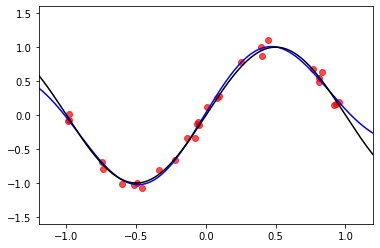

In [50]:
def f(x):
    return np.sin(np.pi * x)
    # return 0.8 * x + 0.2

low = -1.0
high = 1.0
data = rng.uniform(low=low, high=high, size=30)
out = f(data) + np.random.normal(loc=0.0, scale=0.1, size=data.shape[0])

left, right = margin(low, high)
down, up = margin(-1.0, 1.0, margin_rate=0.3)

models = {
    "gauss": LinearRegressionFactory.gauss(
        data, out, num=9, low=low - 0.1, high=high + 0.1, sigma=0.5, lamb=0.01
    ),
    "line": LinearRegressionFactory.line(data, out),
    "polynomial": LinearRegressionFactory.polynomial(data, out, dim=10, lamb=0),
    "sin_cos": LinearRegressionFactory.sin_cos(data, out, max_frequency=9),
}

linear = models["gauss"]
# linear.print_funcs()
linear.fit()


x = np.linspace(left, right, 2000)
# plot_funcs(x, linear, weight=True)

y= linear.predict(x)
plt.scatter(data, out, color=(1, 0, 0, 0.7))
plt.plot(x, y, color="blue")
plt.plot(x, f(x), color="black")

plt.xlim(left, right)
plt.ylim(down, up)
plt.savefig("linear.png")